# 7 Fine-tuning to follow instruction

!["7.3"](img/7.3.png)

## 7.2 Preparing a dataset for supervised instruction fine-tuning

In [1]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [4]:
print(data[50])

{'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [5]:
print(data[999])

{'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [6]:
# Alpaca-style input format

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describe a task. "
        f"Write a response that appropriately complete the request."
        f"\n\n### Instruction: \n{entry['instruction']}"
    )

    input_text = (
        f"\n\n### Input: \n{entry['input']}" if entry['input'] else ""
    )

    return instruction_text + input_text

In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
Identify the correct spelling of the following word.

### Input: 
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [10]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [11]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion: train_portion+test_portion]
val_data = data[train_portion+test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches

!["7.6"](img/7.6.png)

In [15]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []

        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text

            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [16]:
def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor


In [17]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [18]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []
    target_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])
        inputs_lst.append(inputs)
        target_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    target_tensor = torch.stack(target_lst).to(device)
    return inputs_tensor, target_tensor

In [19]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [50]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [51]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [57]:
logits1 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5]])
targets1 = torch.tensor([0, 1])
loss1 = torch.nn.functional.cross_entropy(logits1, targets1)
print(loss1)

logits2 = torch.tensor([[-1.0, 1.0], [-0.5, 1.5], [-0.5, 1.5]])
targets2 = torch.tensor([0, 1, 1])
loss2 = torch.nn.functional.cross_entropy(logits2, targets2)
print(loss2)

targets3 = torch.tensor([0, 1, -100])
loss3 = torch.nn.functional.cross_entropy(logits2, targets3)
print(loss3)

tensor(1.1269)
tensor(0.7936)
tensor(1.1269)


1. As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
By default, PyTorch has the cross_entropy(..., ignore_index=-100) setting to ignore examples corresponding to the label -100

2. Using this -100 ignore_index, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length

3. However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

## 7.4 Creating data loaders for an instruction dataset

In [58]:
device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(device)

xpu


In [59]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [60]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [82]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 89]) torch.Size([8, 89])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 63]) torch.

In [70]:
print(inputs[0])
print(token_ids_to_text(inputs[0], tokenizer))

tensor([21106,   318,   281, 12064,   326,  6901,   257,  4876,    13, 19430,
          257,  2882,   326, 20431,  1844,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   220,   198, 30003,  6525,   262,  6827,  1262,
          257,   985,   576,    13,   198,   198, 21017, 23412,    25,   220,
          198,   464,  5156,   318,   845, 13779,    13,   198,   198, 21017,
        18261,    25,   198,   464,  5156,   318,   355, 13779,   355,   257,
         4936,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256], device='xpu:0')
Below is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
Rewrite the sentence using a simile.

### Input: 
The baby is very cute.

### Response:
The baby is as cute as a button.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [73]:
print(targets[0])
print(token_ids_to_text(targets[0][:-9], tokenizer))

tensor([  318,   281, 12064,   326,  6901,   257,  4876,    13, 19430,   257,
         2882,   326, 20431,  1844,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   220,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   220,   198,
          464,  5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,
           25,   198,   464,  5156,   318,   355, 13779,   355,   257,  4936,
           13, 50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100], device='xpu:0')
 is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
Rewrite the sentence using a simile.

### Input: 
The baby is very cute.

### Response:
The baby is as cute as a button.<|endoftext|>


## 7.5 Loading a pretrained LLM

In [64]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 38.5kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 910kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 45.4kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [18:11<00:00, 1.30MiB/s]  
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 5.20MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 772kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 536kiB/s] 


In [65]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [66]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [69]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


## 7.6 Fine-tuning the LLM on instruction data

In [74]:
from previous_chapters import calc_loss_loader, train_model_simple

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.111923599243164
Validation loss: 4.035695505142212


In [75]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.809, Val loss 2.789
Ep 1 (Step 000005): Train loss 1.188, Val loss 1.124
Ep 1 (Step 000010): Train loss 0.838, Val loss 0.946
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.913
Ep 1 (Step 000020): Train loss 0.762, Val loss 0.860
Ep 1 (Step 000025): Train loss 0.740, Val loss 0.839
Ep 1 (Step 000030): Train loss 0.774, Val loss 0.815
Ep 1 (Step 000035): Train loss 0.696, Val loss 0.790
Ep 1 (Step 000040): Train loss 0.653, Val loss 0.785
Ep 1 (Step 000045): Train loss 0.614, Val loss 0.769
Ep 1 (Step 000050): Train loss 0.649, Val loss 0.763
Ep 1 (Step 000055): Train loss 0.740, Val loss 0.744
Ep 1 (Step 000060): Train loss 0.698, Val loss 0.729
Ep 1 (Step 000065): Train loss 0.638, Val loss 0.720
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.720
Ep 1 (Step 000075): Train loss 0.552, Val loss 0.711
Ep 1 (Step 000080): Train loss 0.590, Val loss 0.703
Ep 1 (Step 000085): Train loss 0.499, Val loss 0.691
Ep 1 (Step 000090): Train loss 0.547, Val loss

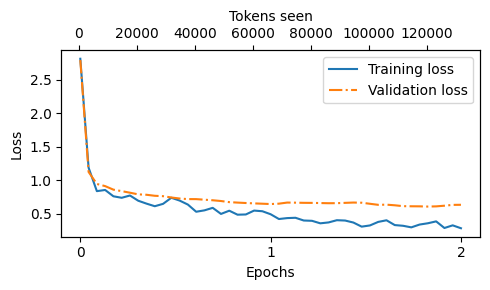

In [76]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 7.7 Extracting and saving responses

In [77]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
Rewrite the sentence using a simile.

### Input: 
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cumulus cloud that is formed when thunderstorms produce a dense, fast-moving, and intense updraft of air.
-------------------------------------
Below is an instruction that describe a task. Write a response that appropriately complete the request.

### Instruction: 
Name the author of 'Pride and Prejudice'.

Correct response:


In [78]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [02:56<00:00,  1.60s/it]


In [79]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [80]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## 7.8 Evaluating the fine-tuned LLM